<a href="https://colab.research.google.com/github/ananyas168/GAN/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/MyDrive/WORK/GAN

/content/drive/MyDrive/WORK/GAN


## we load the CIFAR DATASET
The dataset is comprised of 60,000 32×32 pixel color photographs of objects from 10 classes, such as frogs, birds, cats, ships, airplanes, etc.

In [ ]:
# example of loading the cifar10 dataset
from keras.datasets.cifar10 import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (50000, 32, 32, 3) (50000, 1)
Test (10000, 32, 32, 3) (10000, 1)


##the next cell basically prints the loaded data CIFAR 

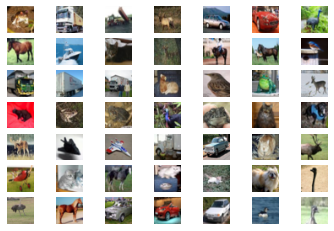

In [ ]:
from matplotlib import pyplot

# plot images from the training dataset
for i in range(49):
	# define subplot
	pyplot.subplot(7, 7, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainX[i])
pyplot.show()


##DISCRIMINATOR MODEL
The model must take a sample image from our dataset as input(32x32x3
 ) and output a classification prediction(0-fake,1-real) as to whether the sample is real or fake aka a binary classification problem.


A normal convolutional layer followed by three convolutional layers using 

* a normal convolutional layer  
* three convolutional layers using a stride of 2×2 with LeakyReLU instead of ReLU
* a single node in the output layer with the sigmoid activation

The model is trained to minimize the binary cross entropy loss function, appropriate for binary classification.

i also tried increasing performance using Dropout, and using the Adam version of stochastic gradient descent with a learning rate of 0.0002 and a momentum of 0.5.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         2

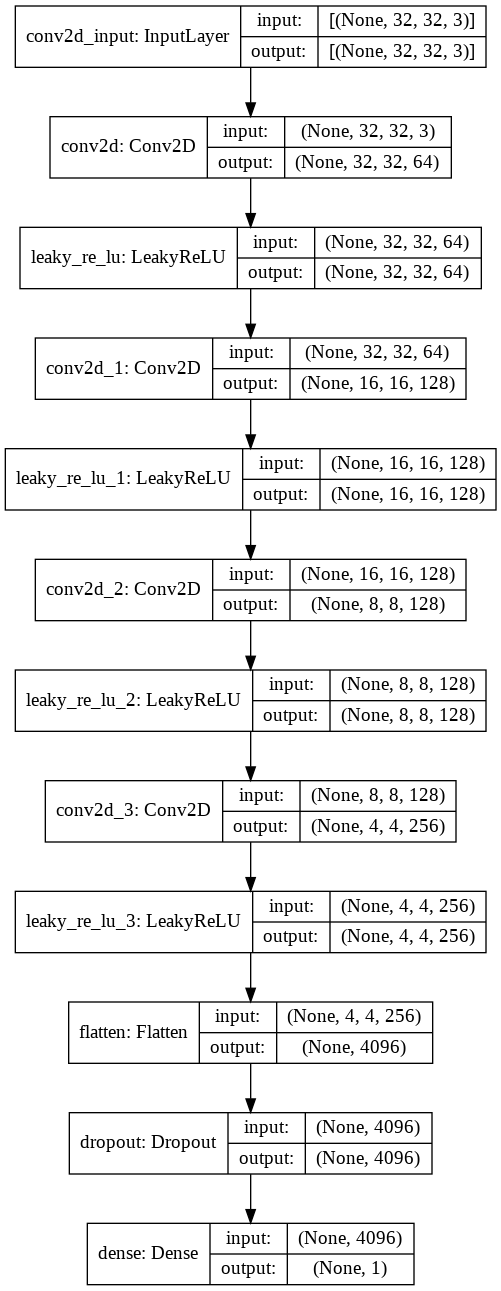

In [ ]:
# example of defining the discriminator model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

A lot of GAN models used pretrained weights for the discriminator but here i tried to trained it using fake generated samples using the function generate_fake_samples() as you can see in the code below. then i train the whole discriminator model to see hiow it learns to distinguinsh fake images and real images. by 19 epochs it learns to discriminate the fake and real properly.

## below is the trained discriminator model

for complete training 

In [ ]:
# example of training the discriminator model on real and random cifar10 images
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU

# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# load and prepare cifar10 training images
def load_real_samples():
	# load cifar10 dataset
	(trainX, _), (_, _) = load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(32 * 32 * 3 * n_samples)
	# update to have the range [-1, 1]
	X = -1 + X * 2
	# reshape into a batch of color images
	X = X.reshape((n_samples, 32, 32, 3))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# train the discriminator model
def train_discriminator(model, dataset, n_iter=20, n_batch=2048):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

# define the discriminator model
model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)

>1 real=49% fake=0%
>2 real=98% fake=4%
>3 real=97% fake=24%
>4 real=96% fake=67%
>5 real=94% fake=96%
>6 real=92% fake=100%
>7 real=89% fake=100%
>8 real=89% fake=100%
>9 real=90% fake=100%
>10 real=93% fake=100%
>11 real=94% fake=100%
>12 real=94% fake=100%
>13 real=97% fake=100%
>14 real=98% fake=100%
>15 real=99% fake=100%
>16 real=99% fake=100%
>17 real=100% fake=100%
>18 real=99% fake=100%
>19 real=100% fake=100%
>20 real=100% fake=100%


##GENERATOR MODEL
The generator model is responsible for creating new, fake, but plausible small photographs of objects.

**Inputs**: Point in latent space, e.g. a 100-element vector of Gaussian random numbers.

**Outputs**: Two-dimensional square color image (3 channels) of 32 x 32 pixels with pixel values in [-1,1]


Model description:


*   a dense layer
*   three con2Dtranspose layer for upsampling with LeakyRELU rathen than  relu
*  a conv2D layer to give 32x32x3 image output with A tanh activation is used to ensure output values are in the desired range of [-1,1], a current best practice.



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16, 16, 128)      

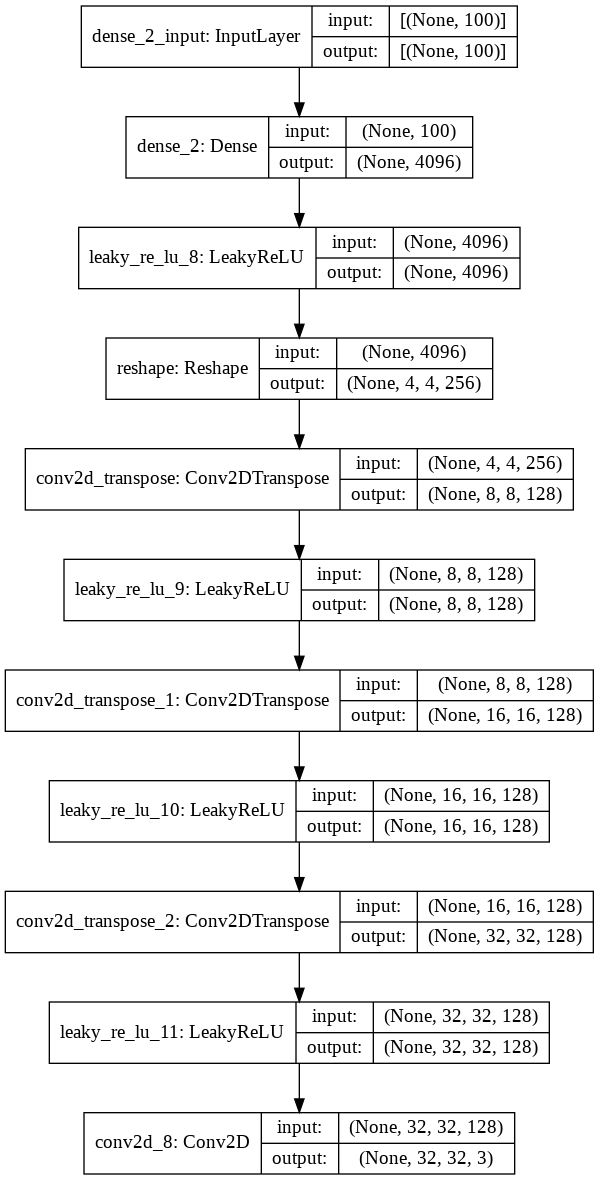

In [ ]:
# example of defining the generator model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In order to feed the generator with latent sppace a function is used named generate_latent_points() 

```
# This is formatted as code

def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
```
along with generate_fake_samples() so that the generator can be trained to produce 32X32x3 fake images similar to real oimages so that iut can fool,the discriminator


## TRAINING OF GENERATIVE MODEL:
the generative model is trained my coupling the generator an dduscriminatir moidel with only generator part of weights are updated and discriminator weights are freezed ans we have already trained trhe duscriminatir training ut furthter will cause the discriminatir mire stronger than geberator and it wont allow the generator model to fool it.

by using:

d_model.trainable = False

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 32, 32, 3)         1466115   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 522497    
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


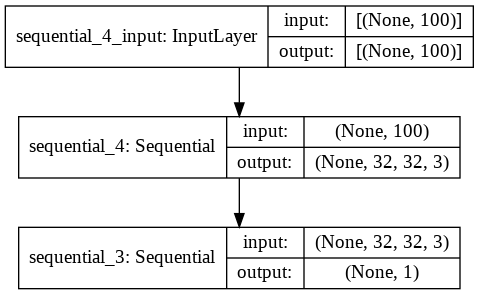

In [ ]:
# demonstrate creating the three models in the gan
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model

# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

## complete GAN model with evaluation function
below the code has all the evaluation metrics needed to know the performance of GAN over the no of epochs of 200 

In [ ]:
# example of a dcgan on cifar10
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load and prepare cifar10 training images
def load_real_samples():
	# load cifar10 dataset
	(trainX, _), (_, _) = load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
>188, 73/390, d1=0.547, d2=0.574 g=1.486
>188, 74/390, d1=0.471, d2=0.391 g=1.551
>188, 75/390, d1=0.616, d2=0.494 g=1.452
>188, 76/390, d1=0.485, d2=0.388 g=1.484
>188, 77/390, d1=0.524, d2=0.482 g=1.344
>188, 78/390, d1=0.521, d2=0.535 g=1.506
>188, 79/390, d1=0.504, d2=0.408 g=1.390
>188, 80/390, d1=0.469, d2=0.375 g=1.387
>188, 81/390, d1=0.529, d2=0.546 g=1.343
>188, 82/390, d1=0.506, d2=0.522 g=1.496
>188, 83/390, d1=0.538, d2=0.523 g=1.505
>188, 84/390, d1=0.558, d2=0.460 g=1.443
>188, 85/390, d1=0.570, d2=0.444 g=1.419
>188, 86/390, d1=0.480, d2=0.391 g=1.340
>188, 87/390, d1=0.337, d2=0.545 g=1.432
>188, 88/390, d1=0.453, d2=0.548 g=1.468
>188, 89/390, d1=0.534, d2=0.414 g=1.551
>188, 90/390, d1=0.543, d2=0.369 g=1.426
>188, 91/390, d1=0.508, d2=0.368 g=1.443
>188, 92/390, d1=0.495, d2=0.554 g=1.534
>188, 93/390, d1=0.427, d2=0.521 g=1.555
>188, 94/390, d1=0.542, d2=0.385 g=1.540
>188, 95/390, d1=0.491, d2=0.488 g=1.347
>188, 

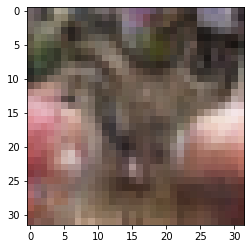

In [ ]:
# example of generating an image for a specific point in the latent space
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
# load model
model = load_model('/content/drive/MyDrive/WORK/GAN/generator_model_200.h5')
# all 0s
vector = asarray([[0.99 for _ in range(100)]])
# generate image
X = model.predict(vector)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
pyplot.imshow(X[0, :, :])
pyplot.show()